In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
# 读入基础数据
## 确定是读入训练集进行训练，还是读入测试集生成提交结果
### 仅训练集
rawData = pd.read_csv('D:\\tx\\pre\\train.csv')
### 训练集和测试集。注意这里把训练集也读入了，为了dummy的时候划分一致。后续需要删除训练集数据
# rawData = pd.read_csv('D:\\tx\\pre\\train.csv')
# rawData.drop(['conversionTime'],axis=1,inplace=True) #先去除conversionTime
# rawData.insert(0, 'instanceID', pd.Series(np.zeros(rawData['label'].count())))#插入instanceID使append不会乱序
# rawData = pd.concat([rawData,pd.read_csv('D:\\tx\\pre\\test.csv')])
## 将部分数据读入
rawData['date'] = rawData['clickTime'].apply(lambda x: int(x/10000))
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\pre\\user.csv'), on='userID')
rawData['hometowncity'] = rawData['hometown'].apply(lambda x: int(x/100))
rawData['residencecity'] = rawData['residence'].apply(lambda x: int(x/10000))
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\pre\\ad.csv'), on='creativeID')
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\pre\\position.csv'), on='positionID')

In [3]:
rawData.columns

Index([u'label', u'clickTime', u'conversionTime', u'creativeID', u'userID',
       u'positionID', u'connectionType', u'telecomsOperator', u'date', u'age',
       u'gender', u'education', u'marriageStatus', u'haveBaby', u'hometown',
       u'residence', u'hometowncity', u'residencecity', u'adID', u'camgaignID',
       u'advertiserID', u'appID', u'appPlatform', u'sitesetID',
       u'positionType'],
      dtype='object')

In [4]:
# 对点击时间进行处理
def dealTime(clicktime):
    hour = int(str(clicktime)[2:4])
    minute = int(str(clicktime)[4:6])
    x = int(60*hour+minute)/30
    if x in [18,19,20]:
        return 1
    elif x in [21,22,23]:
        return 2
    elif x in [4,24]:
        return 3
    elif x in [25,26]:
        return 4
    elif x in [2,3,6,10,27,31,47]:
        return 5
    elif x in [0,1,5,7,8,9,11,28,30,44,45]:
        return 6
    elif x in [13,14]:
        return 8
    elif x in [15]:
        return 9
    else: #中下的最多，所以else来处理
        return 7

In [5]:
# 读入更多特征
## 读入age
rawData.drop(['age'], axis=1, inplace=True) #有些原有字段中有的但经过处理的，先删除，再读入
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\age.csv'), on='userID')
## 读入appCategory
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\appCategory.csv'), on='creativeID')
## 读入clickTime_hour
rawData['clickTime_hour'] = rawData['clickTime'].apply(dealTime)
## 读入lastNCVR_advertiserID
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\lastNCVR_advertiserID.csv'), on=['date', 'creativeID'])
## 读入lastNCVR_appID
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\lastNCVR_appID.csv'), on=['date', 'creativeID'])
## 读入lastNCVR_positionType
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\lastNCVR_positionType.csv'), on=['date', 'positionID'])
## 读入lastNCVR_sitesetID
rawData = pd.merge(rawData, pd.read_csv('D:\\tx\\feature\\lastNCVR_sitesetID.csv'), on=['date', 'positionID'])


# old
# def readFeature(features):
#     for feature in features:
#         global rawData #声明data是global而不是局部变量
#         dataFeature = pd.read_csv('C:\\Users\\work\\Desktop\\tencent\\feature\\train\\' + feature + '.csv', names=[feature])
#         rawData = pd.concat([rawData, dataFeature], axis=1)
# # 有些原有字段中有的但经过处理的，先删除，再读入
# rawData.drop(['age'], axis=1, inplace=True)
# # 读入特征
# readFeature(['lastNCVR_appID','lastNCVR_advertiserID','lastNCVR_positionType','lastNCVR_sitesetID','appCategory', 'age', 'clickTime_hour'])

In [6]:
print rawData.columns

Index([u'label', u'clickTime', u'conversionTime', u'creativeID', u'userID',
       u'positionID', u'connectionType', u'telecomsOperator', u'date',
       u'gender', u'education', u'marriageStatus', u'haveBaby', u'hometown',
       u'residence', u'hometowncity', u'residencecity', u'adID', u'camgaignID',
       u'advertiserID', u'appID', u'appPlatform', u'sitesetID',
       u'positionType', u'age', u'appCategory', u'clickTime_hour',
       u'lastNCVR_advertiserID', u'lastNCVR_appID', u'lastNCVR_positionType',
       u'lastNCVR_sitesetID'],
      dtype='object')


In [7]:
# 特征哑变量化与离散化
import sklearn.preprocessing as preprocessing
## 离散变量哑变量化
def featureDummy(features):
    for feature in features:
        global rawData #声明data是global而不是局部变量
        dummies = pd.get_dummies(rawData[feature], prefix=feature)
        rawData = pd.concat([rawData, dummies], axis=1)
        rawData.drop([feature], axis=1, inplace=True)
## 连续变量标准化
def featureScale(features):
    for feature in features:
        global rawData #声明data是global而不是局部变量
        scaler = preprocessing.StandardScaler()
        scaleParam = scaler.fit(rawData[feature])
        rawData[feature] = scaler.fit_transform(rawData[feature], scaleParam)

# 哑变量化与离散化
# featureDummy(['connectionType', 'telecomsOperator', 'gender'])
featureDummy(['connectionType', 'telecomsOperator', 'gender','marriageStatus','haveBaby', 'appPlatform', 
              'education', 'sitesetID','positionType','appCategory', 'age', 'clickTime_hour'])
featureScale(['lastNCVR_appID', 'lastNCVR_advertiserID','lastNCVR_positionType', 'lastNCVR_sitesetID'])

C:\Users\work\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\work\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\work\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single featur

In [ ]:
data['age_education'] = data.apply(lambda x:data['age']*data['education'], axis=1)

In [ ]:
rawData.head()

In [7]:
# 提取特征
## 筛掉一些字段
# data = rawData.drop(['clickTime', 'conversionTime', 'creativeID', 'userID', 'positionID', 'date', 'hometown', 'residence','advertiserID', 'adID', 'camgaignID'], axis=1)
data = rawData.drop(['appID', 'clickTime','conversionTime', 'creativeID', 'userID', 'positionID', 'date', 'hometowncity', 'residencecity', 'hometown', 'residence','advertiserID', 'adID', 'camgaignID'], axis=1)
# data = data.filter(regex='label|connectionType_*|telecomsOperato_*|appPlatform_*|lastNCVR_appID_+|lastNCVR_advertiserID_+')
print data.columns

Index([u'label', u'connectionType', u'telecomsOperator', u'gender',
       u'education', u'marriageStatus', u'haveBaby', u'appPlatform',
       u'sitesetID', u'positionType', u'age', u'appCategory',
       u'clickTime_hour', u'lastNCVR_advertiserID', u'lastNCVR_appID',
       u'lastNCVR_positionType', u'lastNCVR_sitesetID'],
      dtype='object')


     label  connectionType  telecomsOperator  gender  education  \
age                                                               
0     8956            8956              8956    8956       8956   
1      941             941               941     941        941   
8      176             176               176     176        176   
9      400             400               400     400        400   
10    1220            1220              1220    1220       1220   
11    2726            2726              2726    2726       2726   
12    3232            3232              3232    3232       3232   
13    4078            4078              4078    4078       4078   
14    3644            3644              3644    3644       3644   
15    4952            4952              4952    4952       4952   
16    4110            4110              4110    4110       4110   
17    3728            3728              3728    3728       3728   
18    3764            3764              3764    3764       376

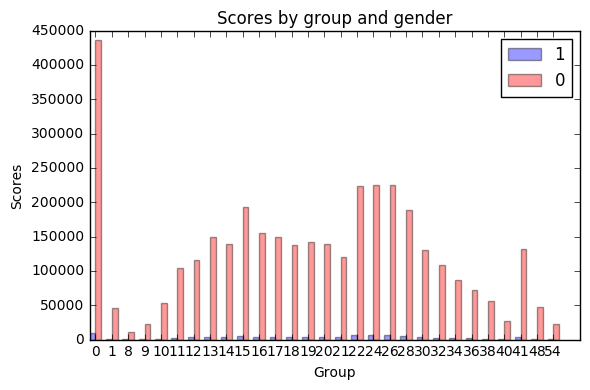

In [88]:
print data[data['label']==1].groupby('age').count()
agelist1 = data[data['label']==1].groupby('age').count()
agelist0 = data[data['label']==0].groupby('age').count()
print len(list(agelist.index)),list(agelist["label"])
n_groups = len(list(agelist.index)) 
fig, ax = plt.subplots()  
index = np.arange(n_groups)  
bar_width = 0.35     
opacity = 0.4  
rects1 = plt.bar(index, list(agelist1["label"]), bar_width,alpha=opacity, color='b',label='1')
rects0 = plt.bar(index+bar_width, list(agelist0["label"]), bar_width,alpha=opacity, color='r',label='0')
plt.xlabel('Group')  
plt.ylabel('Scores')  
plt.title('Scores by group and gender')  
plt.xticks(index + bar_width, list(agelist.index))  
plt.ylim(0,450000)  
plt.legend()    
plt.tight_layout()  
plt.show()  


# 训练分类器

In [8]:
# 平衡正反例
def balance(train_pro):
    ## 从正例中随机取出比例为a的数据，划分
    train_size_p = int(data[data['label']==1]['label'].count()*train_pro)
    train_size_n = int(train_size_p * 39.02) #原始样本中负例是正例的这个倍数
    sampler1 = np.random.permutation(data[data['label']==1]['label'].count())
    index1 = data[data['label']==1].index[sampler1] #重排序后的索引
    train1 = data[data['label']==1].ix[index1[:train_size_p]]
    test1 = data[data['label']==1].ix[index1[train_size_p:]]
    ## 从负例中随机取出相同数量的数据，划分
    sampler0 = np.random.permutation(data[data['label']==0]['label'].count())
    index0 = data[data['label']==0].index[sampler0] #重排序后的索引
    train0 = data[data['label']==0].ix[index0[:train_size_n]]
    test0 = data[data['label']==0].ix[index0[train_size_n:]]
    ## 构建训练集和测试集
    data_train = pd.concat([train1, train0])
    data_test = pd.concat([test1, test0])
    return data_train.as_matrix()[:,1:], data_test.as_matrix()[:,1:], data_train.as_matrix()[:,0],  data_test.as_matrix()[:,0]
# 获取正反例
x_train, x_test, y_train, y_test = balance(0.8)

In [ ]:
# 划分训练集和测试集
from sklearn import cross_validation
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
# X = all_data.as_matrix()[:,1:]
# y = all_data.as_matrix()[:,0]
# trainX, testX, trainY, testY = cross_validation.train_test_split(X, y, test_size=0.2, random_state=174)
# y
# 训练
clf = linear_model.LogisticRegressionCV(Cs=10, penalty='l2', tol=1e-4, n_jobs=-1, cv=5)
# clf = RandomForestClassifier()
clf.fit(trainX, trainY)
print clf

In [9]:
# 评估模型结果
import scipy as sp
from sklearn.cross_validation import train_test_split
# import LightGBM
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll
x = data.as_matrix()[:,1:]
y = data.as_matrix()[:,0]
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
# XGBoost  
data_train = xgb.DMatrix(x_train, label=y_train)  
data_test = xgb.DMatrix(x_test, label=y_test)  
watch_list = [(data_test, 'eval'), (data_train, 'train')]  
param = {'max_depth': 8, 'eta': 0.8, 'silent': 1, 'objective': 'binary:logistic', }  
bst = xgb.train(param, data_train, num_boost_round=50, evals=watch_list)  
y_hat = bst.predict(data_test)  
print logloss(y_test, y_hat) 

[0]	eval-error:0.024419	train-error:0.024966
[1]	eval-error:0.024441	train-error:0.024969
[2]	eval-error:0.024415	train-error:0.024967
[3]	eval-error:0.024416	train-error:0.024969
[4]	eval-error:0.024413	train-error:0.024968
[5]	eval-error:0.024431	train-error:0.024964
[6]	eval-error:0.024432	train-error:0.024962
[7]	eval-error:0.024441	train-error:0.024959
[8]	eval-error:0.024445	train-error:0.024962
[9]	eval-error:0.024441	train-error:0.024964
[10]	eval-error:0.024449	train-error:0.024963
[11]	eval-error:0.024450	train-error:0.024961
[12]	eval-error:0.024454	train-error:0.024956
[13]	eval-error:0.024455	train-error:0.024954
[14]	eval-error:0.024449	train-error:0.024950
[15]	eval-error:0.024451	train-error:0.024948
[16]	eval-error:0.024450	train-error:0.024949
[17]	eval-error:0.024462	train-error:0.024947
[18]	eval-error:0.024462	train-error:0.024947
[19]	eval-error:0.024461	train-error:0.024944
[20]	eval-error:0.024459	train-error:0.024938
[21]	eval-error:0.024463	train-error:0.02493

0.10498402788


In [ ]:
print x_train[:10]

In [10]:
# 保存分类器
from sklearn.externals import joblib
joblib.dump(bst, 'D:\\tx\\clf\\xgb_1.pkl', compress=3)

['D:\\tx\\clf\\xgb_1.pkl']

# 特征赛选

In [16]:
import pandas as pd
import matplotlib.pylab as plt
feat_imp = pd.Series(bst.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

AttributeError: 'Booster' object has no attribute 'booster'

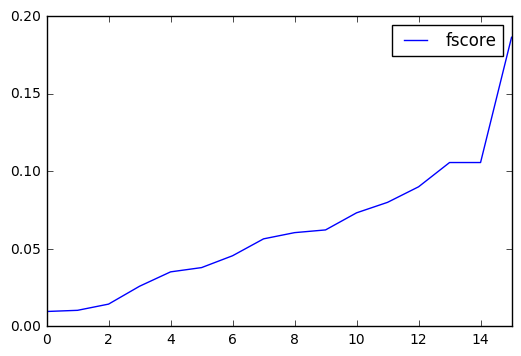

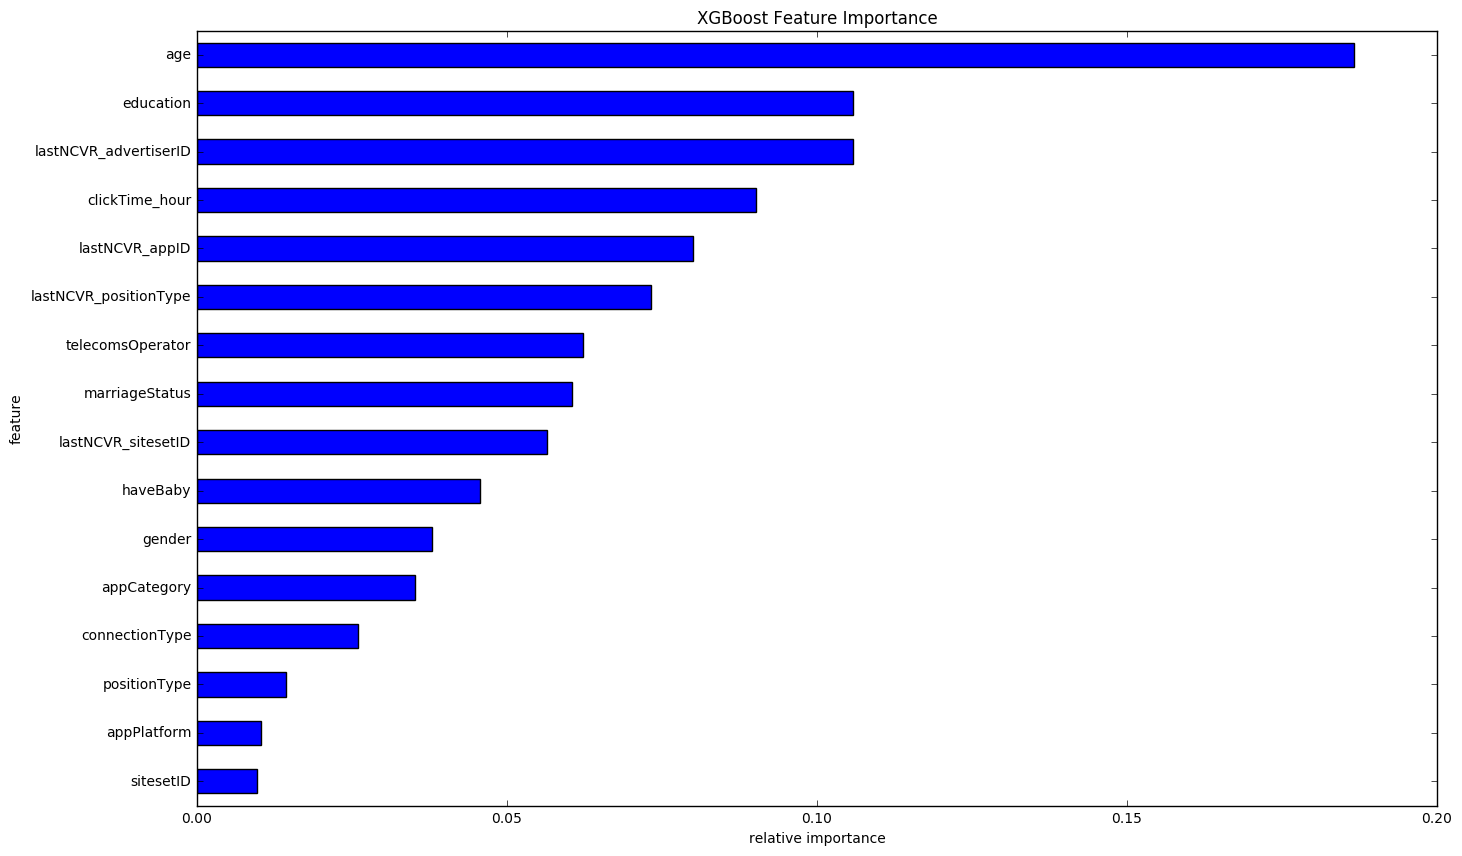

In [28]:
import operator
import matplotlib.pylab as plt

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

features = [x for x in data.columns if x not in ['label']]  
ceate_feature_map(features)      
importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

# plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(16, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')
plt.show()

# 预测